# Featurize spectra previously written by using polynomials

### Goals:
- Generate polynomial featurized XY files

## Inputs:
- {}\_{}\_XY.json

## Outputs:
 - {}\_{}\_polynomials_XY.json

In [29]:
target_elements_groups=[('Ti','O'),('V','O'),('Cr','O'),
                        ('Mn','O'),('Fe','O'),('Co','O'),
                        ('Ni','O'),('Cu','O')]

target_metals = set(['Co','Ni','Fe','Cr','V','Mn','Cu','Ti'])
target_elements_sets =[set(pair) for pair in target_elements_groups]


## If the below flag is set to False, write polynomials for the entire set. 
## If the below flag is set to True, write polynomials for the pre / post region separately.

In [30]:
write_pre_post = False

In [38]:
import sys
sys.path.append('/n/home11/storrisi/TRIX/X-Ray-Spectroscopy')

%load_ext autoreload
%autoreload 2
from pymatgen.ext.matproj import MPRester
from pymatgen.core import Structure
from pymatgen.analysis.structure_matcher import StructureMatcher, ElementComparator
from trixs.spectra.core import XAS_Spectrum, XAS_Collation
from trixs.spectra.util import NumpyEncoder
import matplotlib
from tqdm import tqdm, tqdm_notebook
from pprint import pprint
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from trixs.spectra.spectrum_featurize import polynomialize_by_idx, gauge_polynomial_error
#from pandas import DataFrame

storage_directory = '/Users/steven/Documents/Research/Projects/TRIX/data/final_XY'
storage_directory = '/n/home11/storrisi/TRIX/data/final_XY/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
data_set = 'november'

data_by_pair = {pair:[] for pair in target_elements_groups[:2]}
for pair in target_elements_groups:
    file_target = storage_directory+'/{}_{}_XY_feff_{}.json'.format(pair[0],pair[1],data_set)
    #file_target = storage_directory+'/{}_{}_XY_MP_only_{}.json'.format(pair[0],pair[1],data_set)
    with open(file_target,'r') as f:
        data_by_pair[pair] = [json.loads(line) for line in f.readlines()]


In [33]:
def prune_outliers(mu):
    
    if mu[-1]==np.max(mu):
        return False
    
    if np.max(mu)>3:
        return False
    
    if np.max(mu) in mu[:10]:
        return False
    
    return True

In [34]:
def test_poly_error_fit(X_set,idxs,x_domain,error_bound=.1, use_norm = True):
    idx_keep = []
    
    for spec,idx in zip(X_set,idxs):
        
        within_bound = one_shot_poly_error_fit(x_domain,spec,
                                               use_norm=use_norm,error_bound=error_bound)
        
        if not within_bound:
            continue
        idx_keep.append(idx)
            
    print("Dropped {}".format(len(idxs)-len(idx_keep)))
    return idx_keep


def one_shot_poly_error_fit(x_domain, mu,use_norm = True, error_bound = .1):
    
    if use_norm:
        poly_set = polynomialize_by_idx(x_domain,mu/np.max(mu),N=20,deg=3,label_type='frac')
    else:
        poly_set = polynomialize_by_idx(x_domain,mu,N=20,deg=3,label_type='frac')
    
    for poly in poly_set:
            poly.error = gauge_polynomial_error(poly.x,poly.y,poly,error='abs')
            if poly.error>.1:
                return False


    return True
    

## No pre/post edge


For ('Ti', 'O'): Ineligible:57, Outliered: 26, Excluded: 54


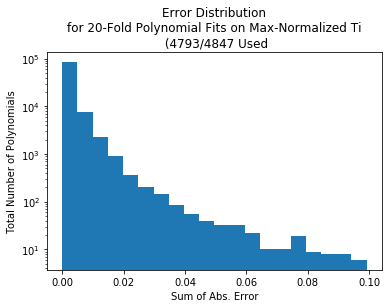


For ('V', 'O'): Ineligible:30, Outliered: 12, Excluded: 149


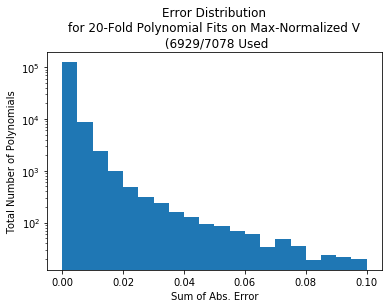


For ('Cr', 'O'): Ineligible:8, Outliered: 18, Excluded: 121


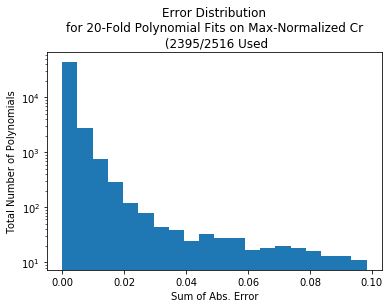


For ('Mn', 'O'): Ineligible:42, Outliered: 504, Excluded: 41


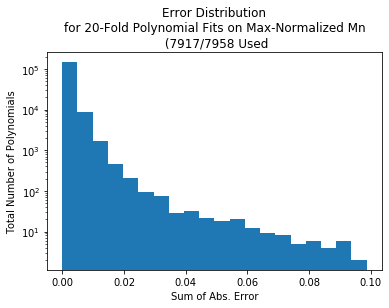


For ('Fe', 'O'): Ineligible:25, Outliered: 523, Excluded: 70


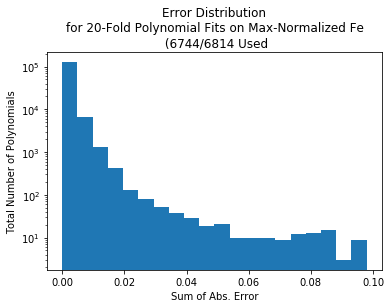


For ('Co', 'O'): Ineligible:7, Outliered: 66, Excluded: 7


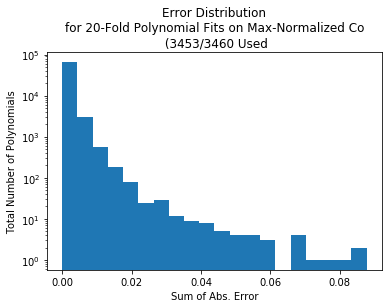


For ('Ni', 'O'): Ineligible:11, Outliered: 12, Excluded: 1


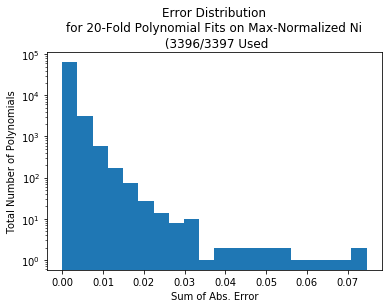


For ('Cu', 'O'): Ineligible:21, Outliered: 31, Excluded: 0


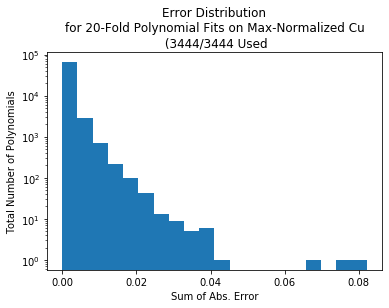


For ('Ti', 'O'): Ineligible:57, Outliered: 26, Excluded: 54


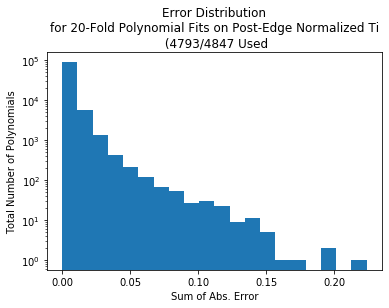


For ('V', 'O'): Ineligible:30, Outliered: 12, Excluded: 149


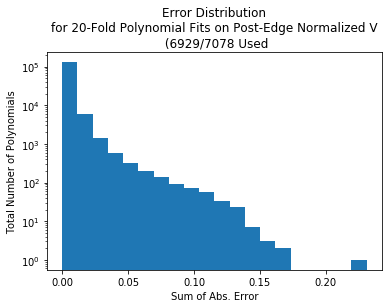


For ('Cr', 'O'): Ineligible:8, Outliered: 18, Excluded: 121


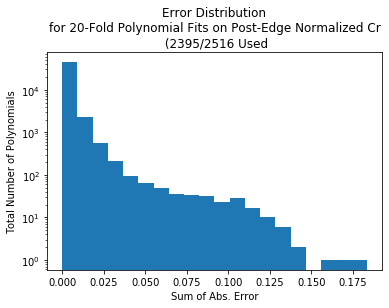


For ('Mn', 'O'): Ineligible:42, Outliered: 504, Excluded: 41


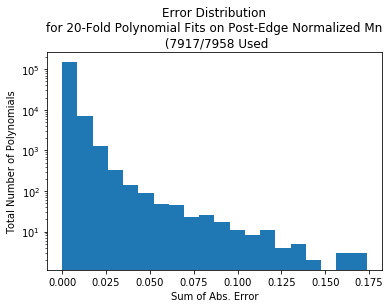


For ('Fe', 'O'): Ineligible:25, Outliered: 523, Excluded: 70


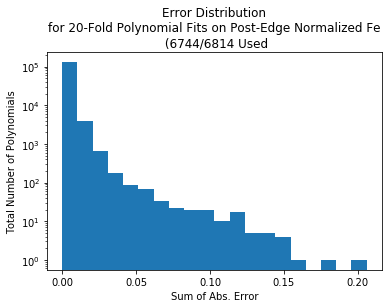


For ('Co', 'O'): Ineligible:7, Outliered: 66, Excluded: 7


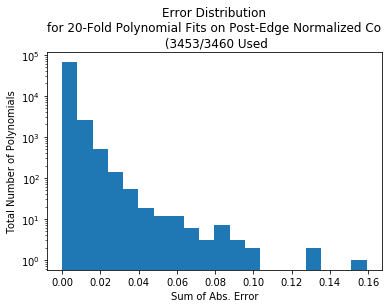


For ('Ni', 'O'): Ineligible:11, Outliered: 12, Excluded: 1


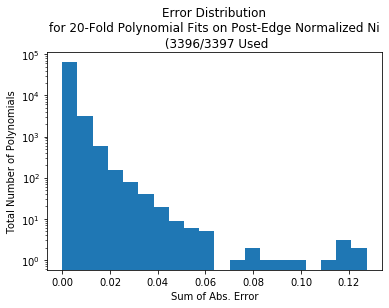


For ('Cu', 'O'): Ineligible:21, Outliered: 31, Excluded: 0


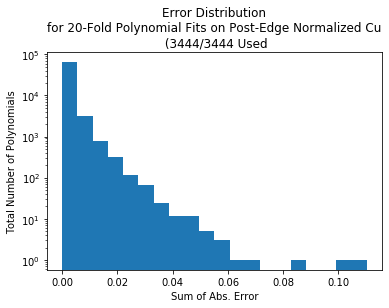

In [42]:
polynomials_by_pair = {pair:[] for pair in target_elements_groups}

max_normalized = True
for max_normalized in [True,False]:
    for pair in target_elements_groups:
        #feffnorm or maxnorm
        if max_normalized:
            target_file = storage_directory + '/{}_{}_feff_maxnorm_{}_polys_whole_curve_XY.json'.format(pair[0],pair[1],data_set)
        else:
            target_file = storage_directory + '/{}_{}_feff_feffnorm_{}_polys_whole_curve_XY.json'.format(pair[0],pair[1],data_set)
        #target_file = storage_directory + '/{}_{}_MP_only_{}_polys_whole_curve_XY.json'.format(pair[0],pair[1],data_set)


        with open(target_file,'w') as f:
            errors = []
            ineligible = 0 
            outliers = 0
            unfeaturized = 0
            written = 0 
            cond_nums = []
            for dat in tqdm_notebook(data_by_pair[pair],desc=pair[0]):
                
                
                if not (dat.get('bader') or dat.get('coordination') in [4,5,6]):
                    ineligible +=1
                    continue
                    
                cur_spec = XAS_Spectrum(dat['E'],dat['mu'])

                if not prune_outliers(cur_spec.y):
                    outliers +=1
                    continue 
                    
                if not one_shot_poly_error_fit(cur_spec.x,cur_spec.y,use_norm=True,error_bound=.1):
                    unfeaturized +=1
                    continue
                    
                if max_normalized:
                    cur_spec.normalize('max')


                cur_cond_nums = []
                cur_errors = []
                poly_set = {}
                peak = cur_spec.get_peak_idx()

                labeled_coefficients = {}
                labeled_coefficients['peak'] = int(peak)# +np.random.uniform(-.001,.001)
                labeled_coefficients['random'] = np.random.uniform(0,1)
                # GET LEFT SIDE
                for n in [4,5,10,20]:
                    poly_set[n] = polynomialize_by_idx(cur_spec.x,cur_spec.y,N=n,deg=3,label_type='frac')
                    for poly in poly_set[n]:
                        cur_cond_nums.append(max(poly.full_data[2])/min(poly.full_data[2]))
                        cond_nums.append(cur_cond_nums[-1])
                        for i, coef in enumerate(poly.coef):
                            coefficient_label = 'loc:all,'+poly.label +',coef:' +str(i)
                            labeled_coefficients[coefficient_label] = coef
                        if n == 20:
                            poly.error = gauge_polynomial_error(poly.x,poly.y,poly,error='abs')
                            cur_errors.append(poly.error)
                #if max(cur_errors)>.10*100:# or max(cur_cond_nums)>10:
                errors+=cur_errors
                dat['labeled_coefficients'] = labeled_coefficients
                write_data = {}
                if not dat.get('labeled_coefficients', False):
                    continue
                write_data['labeled_coefficients'] = dat['labeled_coefficients']
                write_data['coordination'] = dat['coordination']
                write_data['one_hot_coord'] = dat['one_hot_coord']
                write_data['bader'] = dat['bader']
                write_data['guessed_oxy'] = dat.get('guessed_oxy',None)

                write_data['nn_indexes'] = dat.get('nn_indexes')
                write_data['nn_species'] =dat.get('nn_species')
                write_data['nn_dists'] = dat.get('nn_dists')
                write_data['avg_nn_dists'] = np.mean(dat.get('nn_dists'))
                write_data['nn_min-max'] = dat.get('nn_min-max')
                write_data['mp_baders'] = dat.get('mp_baders')
                write_data['oqmd_baders'] = dat.get('oqmd_baders')
                write_data['valid_bader'] = dat.get('valid_bader')

                f.write(json.dumps(write_data) + '\n')
                written +=1
            print(f"For {pair}: Ineligible:{ineligible}, Outliered: {outliers}, Excluded: {unfeaturized}")

            norm_str = 'max' if max_normalized else 'feff'
            norm_title = 'Max-Normalized' if max_normalized else 'Post-Edge Normalized'
            plt.hist(errors,bins=20)
            plt.title(f"Error Distribution\nfor 20-Fold Polynomial Fits on {norm_title} {pair[0]}\n ({written}/{written+unfeaturized} Used")
            plt.xlabel("Sum of Abs. Error")
            plt.yscale('log')

            plt.ylabel("Total Number of Polynomials")
            plt.savefig("../RF/gen_figures/{}_{}_poly_errors.pdf".format(pair[0],norm_str),format='pdf',dpi=300,bbox_inches='tight',transparent=True)
            plt.show()


# Pre vs. Post-Edge Polynomials (Obsolete)

In [ ]:
polynomials_by_pair = {pair:[] for pair in target_elements_groups}

for pair in target_elements_groups:
    continue
    target_file = storage_directory + '/{}_{}_feff_{}_polys_pre-post_XY.json'.format(pair[0],pair[1],data_set)
    #target_file = storage_directory + '/{}_{}_MP_only_{}_polys_pre-post_XY.json'.format(pair[0],pair[1],data_set)
    
    if not write_pre_post:
        continue
    
    with open(target_file,'w') as f:
        errors = []
        excluded = 0 
        outliers = 0
        cond_nums = []
        for dat in tqdm_notebook(data_by_pair[pair][::1]):

            cur_spec = XAS_Spectrum(dat['E'],dat['mu'])
            cur_spec.normalize('max')
            
            if not prune_outliers(cur_spec.y):
                outliers +=1
                continue 
            
            cur_cond_nums = []
            peak = cur_spec.get_peak_idx()

            if peak<=20 or peak>=80:
                continue
            pre_x, post_x = cur_spec.x[:peak], cur_spec.x[peak:]
            pre_y, post_y = cur_spec.y[:peak], cur_spec.y[peak:]
            cur_errors = []
            poly_set = {}
            labeled_coefficients = {}
            labeled_coefficients['peak'] = int(peak)#+np.random.uniform(-.001,.001)
            labeled_coefficients['random'] = np.random.uniform(0,1)
            # GET LEFT SIDE
            for n in [1,2,4,5,10]:
                poly_set[n] = polynomialize_by_idx(pre_x,pre_y,N=n,deg=3,label_type='frac')
                for poly in poly_set[n]:
                    cond_nums.append(max(poly.full_data[2])/min(poly.full_data[2]))
                    cur_cond_nums.append(cond_nums[-1])                    
                    for i, coef in enumerate(poly.coef):
                        coefficient_label = 'loc:pre,'+poly.label +',coef:' +str(i)
                        labeled_coefficients[coefficient_label] = coef
                    if n == 10:
                        poly.error = gauge_polynomial_error(poly.x,poly.y,poly,error='abs')
                        cur_errors.append(poly.error)
            # GET RIGHT SIDE
            for n in [1,2,4,5,10]:
                poly_set[n] = polynomialize_by_idx(post_x,post_y,N=n,deg=3,label_type='frac')
                for poly in poly_set[n]:
                    cond_nums.append(max(poly.full_data[2])/min(poly.full_data[2]))
                    cur_cond_nums.append(cond_nums[-1])
                    for i, coef in enumerate(poly.coef):
                        coefficient_label = 'loc:post,'+poly.label +',coef:' +str(i)
                        labeled_coefficients[coefficient_label] = coef
                    if n == 10:
                        poly.error = gauge_polynomial_error(poly.x,poly.y,poly,error='abs')
                        cur_errors.append(poly.error)
                        
            if max(cur_errors)>.05 or max(cur_cond_nums)>10:
                #print(max(cur_cond_nums))
                excluded+=1
                continue
            else:
                errors+=cur_errors

            dat['labeled_coefficients'] = labeled_coefficients
            write_data = {}
            if not dat.get('labeled_coefficients', False):
                continue
            write_data['labeled_coefficients'] = dat['labeled_coefficients']
            write_data['coordination'] = dat['coordination']
            write_data['one_hot_coord'] = dat['one_hot_coord']
            write_data['bader'] = dat['bader']
            write_data['guessed_oxy'] = dat.get('guessed_oxy',None)
            
            write_data['nn_indexes'] = dat.get('nn_indexes')
            write_data['nn_species'] =dat.get('nn_species')
            write_data['nn_dists'] = dat.get('nn_dists')
            write_data['avg_nn_dists'] = np.mean(dat.get('nn_dists'))
            write_data['nn_min-max'] = dat.get('nn_min-max')
            write_data['mp_baders'] = dat.get('mp_baders')
            write_data['oqmd_baders'] = dat.get('oqmd_baders')
            write_data['valid_bader'] = dat.get('valid_bader')
            
            
            f.write(json.dumps(write_data) + '\n')
        print("Excluded for {}: {}".format(pair,excluded))
        plt.hist(errors,bins=20)
        plt.show()
